# Final Project - DFT calculations

## Part 1: Calculations of band gaps and stabilities of perovskites

In this part of the project, you will be considering one of the top 20 perovskite candidates and perform a study of its stability and band gap. For the calculation of the band gap you will have to calculate the band gaps at three different levels of theory, namely:
- Using the PBEsol functions, which as a GGA functional.
- Using the GLLB functional, which is a functional with a corrected potential for the one-electron energies.
- Using GW, which is a many-body perturbation theory method.

In all the cases you will consider the single unit cell of hte perovskite, which indludes only 5 atoms.

In your reports, you need to compare the three levels of theory, and comment on their accuracy. You should also comment on how far/close are the GLLB band gaps from the GW ones, and how much more expensive is one method compared with the others. is the GLLB/GW band gap of your perovskite above 1.7 eV?

Regarding the stability, you will need to calculate the relative energy of the perovskites versus the decompositions in the A and B elements oxides, i.e. you will need to analyze if the reaction $A_nO_m + B_r O_t \rightarrow ABO_3$ is exothermic or endothermic. of course, if the reaction is exothermic you will consider your perovskite stable. If the reaction is endothermic, you will consider that your perovskite could be metastable if the reaction energy is less than 0.20 eV per formula unit of ABO$_3$. For this part, you will use only the PBEsol functional.

In the following, you will find scripts you can use to answer the questions.

First we will be doing the [stability calculations](#Stability-calculations), and then do the [band gap](#Band-gaps) calculations.

**NB**: A pre-existing folder structure has already been created, so please stick to that folder structure, otherwise the scripts will not work.

### Stability calculations

In [1]:
%%writefile relax_O2.py
from os.path import join
from ase.build import molecule
from ase.optimize import BFGS
from gpaw import GPAW, PW
from ase.parallel import paropen
from ase.visualize import view

folder = 'relax/O2'
folder = join(folder, '')  # Ensure trailing '/'

# setting up the system
atoms = molecule('O2', pbc=True)
atoms.center(vacuum=5)

if 0:
    view(atoms)
    assert False  # Break execution
atoms.set_initial_magnetic_moments([1, 1])

calc = GPAW(txt=folder+'O2.out',
            mode=PW(600),
            xc='PBEsol',  # what if we take LDA
            basis='dzp',
            spinpol=True)
atoms.set_calculator(calc)
BFGS(atoms, trajectory=folder+'O2.traj').run(fmax=0.02)
epot = atoms.get_potential_energy()

# Save the energy
with paropen(folder+'energy.dat','w') as f:
    print(f'Energy: {epot:.4f} eV', file=f)

Overwriting relax_O2.py


In [2]:
!qsub.py -p 8 -t 1 relax_O2.py

7473310.hnode2


In [26]:
%%writefile relax_perovskite.py

from os.path import join
import numpy as np
from gpaw import GPAW, PW, FermiDirac
from ase.constraints import StrainFilter
from ase.optimize import BFGS
from ase.parallel import paropen
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase import Atoms

folder = 'relax/perovskite'
folder = join(folder, '')  # Ensure trailing '/'

# --- parameters ---
# Put here the formula of your perovskite, e.g. "CaGeO3"
name = "SrGeO3"

# The planewave cutoff, start with 600eV. 
# If you have time left when you are done with all calculation you can play around with this value to check convergence
ecut = 600
 
# Starting guess for the lattice parameter, this will most likely work well enough 
a = 3.5

# Setting up the perovsktie
atoms = Atoms(symbols=name,
             pbc=True,
             cell=np.array(
                           [[ a,  0.,  0.],
                            [ 0.,  a,  0.],
                            [ 0.,  0.,  a]]
                           ),
             positions=np.array(
                            [[ 0.,  0.,  0.],
                             [ a/2,  a/2,  a/2],
                             [ a/2,  a/2,  0.],
                             [ 0.,  a/2,  a/2],
                             [ a/2,  0.,  a/2]]))

#visualize
if 0:
    view(atoms)
    assert False
# Put in a number of k-points along one direction
# The total k-point grid will be (k,k,k)  
k = 4
k += k%2 # round up to next even number
calc = GPAW(mode=PW(ecut),
            kpts={'size': (k, k, k),'gamma':True},
            xc='PBEsol',
            basis='dzp',
            txt=folder+name+'.out',
            occupations=FermiDirac(width=0.01),
            )

atoms.set_calculator(calc)

# Here we set up the optimizer
# We only optimize the lattice parameter, keeping the relative positions of the atoms fixed
ucf = StrainFilter(atoms)
qn = BFGS(ucf, logfile=folder+"log.log")
traj = Trajectory(folder+name+'.traj', 'w', atoms)
qn.attach(traj)
qn.run(fmax=0.02)
epot = atoms.get_potential_energy()

# diagonalize the full hamiltonian, we need this for the GW calculation
calc.diagonalize_full_hamiltonian()
calc.write(folder+name+'_groundstate.gpw', all)    # write out wavefunctions

# Save the energy 
with paropen(folder+'energy.dat', 'w') as f:
    print(f'Energy: {epot:.4f}', file=f)

Overwriting relax_perovskite.py


In [27]:
!qsub.py -p 8 -t 4 relax_perovskite.py

7473328.hnode2


In [29]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
7473328.hnode2             ...perovskite.py s171629                0 R hpc            


In [6]:
%%writefile relax_oxide1.py
from os.path import join
from gpaw import GPAW, PW, FermiDirac
from ase.constraints import StrainFilter
from ase.optimize import BFGS
from ase.parallel import paropen
from ase.io import read
import numpy as np
from gpaw import setup_paths
from ase.build import niggli_reduce
from ase.visualize import view
from ase.io.trajectory import Trajectory

folder = 'relax/oxide1'
folder = join(folder, '')  # Ensure trailing '/'

#parameters
#put here the formula of one of your oxides here, e.g. "CaO"
oxideName = "SrO"
# The planewave cutoff, start with 600eV. 
# If you have time left when you are done with all calculation you can play around with this value to check convergence
ecut = 600

# pick a reasonable k-point sampling
kpts={'size': (4, 4, 4) ,'gamma':True}

# for reading oxide structure
atoms = read(f"oxides/{oxideName}.traj")
niggli_reduce(atoms) # avoid weird unit cells

if 0:
    view(atoms)
    assert False

calc = GPAW(mode=PW(ecut),
            kpts=kpts,
            xc='PBEsol',
            txt=folder+oxideName+'.out',
            occupations=FermiDirac(width=0.01),
            eigensolver='rmm-diis',
            #symmetry={'point_group': False}
            )

atoms.set_calculator(calc)

# Here we set up the optimizer
# We only optimize the lattice parameter, keeping the relative positions of the atoms fixed
ucf = StrainFilter(atoms)
qn = BFGS(ucf, logfile=folder+"log.log")
traj = Trajectory(folder+oxideName+'.traj', 'w', atoms)
qn.attach(traj)
qn.run(fmax=0.02)
epot=atoms.get_potential_energy()

# Save the energy 
with paropen(folder+'energy.dat','w') as f:
    print(f'Energy: {epot:.4f} eV', file=f)

Overwriting relax_oxide1.py


In [8]:
!qsub.py -p 8 -t 4 relax_oxide1.py

7473312.hnode2


In [7]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
7473310.hnode2             relax_O2.py      s171629         00:11:42 R hpc            
7473311.hnode2             ...perovskite.py s171629         00:04:02 R hpc            


In [9]:
%%writefile relax_oxide2.py
from os.path import join
from gpaw import GPAW, PW, FermiDirac
from ase.constraints import StrainFilter
from ase.optimize import BFGS
from ase.parallel import paropen
from ase.io import read
import numpy as np
from gpaw import setup_paths
from ase.build import niggli_reduce
from ase.visualize import view
from ase.io.trajectory import Trajectory

folder = 'relax/oxide2'
folder = join(folder, '')  # Ensure trailing '/'

#parameters
#put here the formula of one of your oxides here, e.g. "GeO2"
oxideName = "GeO2"
# The planewave cutoff, start with 600eV. 
# If you have time left when you are done with all calculation you can play around with this value to check convergence
ecut = 600

# pick a reasonable k-point sampling
kpts={'size': (4, 4, 4) ,'gamma':True}

# for reading oxide structure
atoms = read(f"oxides/{oxideName}.traj")
niggli_reduce(atoms) # avoid weird unit cells

if 0:
    view(atoms)
    assert False

calc = GPAW(mode=PW(ecut),
            kpts=kpts,
            xc='PBEsol',
            txt=folder+oxideName+'.out',
            occupations=FermiDirac(width=0.01),
            eigensolver='rmm-diis',
            #symmetry={'point_group': False}
            )

atoms.set_calculator(calc)
atoms.get_potential_energy()

# Here we set up the optimizer
# We only optimize the lattice parameter, keeping the relative positions of the atoms fixed
ucf = StrainFilter(atoms)
qn = BFGS(ucf, logfile=folder+"log.log")
traj = Trajectory(folder+oxideName+'.traj', 'w', atoms)
qn.attach(traj)
qn.run(fmax=0.02)
epot=atoms.get_potential_energy()

# Save the energy 
with paropen(folder+'energy.dat','w') as f:
    print(f'Energy: {epot:.4f} eV', file=f)

Overwriting relax_oxide2.py


In [10]:
!qsub.py -p 8 -t 4 relax_oxide2.py

7473313.hnode2


### Band gaps

In [11]:
%%writefile pbesol_bandgap.py
from os.path import join
from gpaw import GPAW, PW, FermiDirac
from ase.parallel import paropen
from ase.io import read
from gpaw import setup_paths
from ase.visualize import view
from ase.dft.kpoints import ibz_points, get_bandpath
from gpaw import setup_paths
from ase.visualize import view
from ase.dft.bandgap import bandgap
from ase.parallel import paropen
import numpy as np

folder = 'bandgap/PBEsol'
folder = join(folder, '')  # Ensure trailing '/'

#parameters
#put here the formula of your perovskite, e.g. "CaGeO3"
name = "SrGeO3"

# The planewave cutoff, start with 600eV. 
# If you have time left when you are done with all calculation you can play around with this value to check convergence
ecut = 600
# Put in a number of k-points along one direction
# The total k-point grid will be (k,k,k)  
k = 4
k += k%2 # round up to next even number

# read the optimized geometry
atoms = read(f'relax/perovskite/{name}.traj')

calc = GPAW(mode=PW(ecut),
            kpts={'size': (k, k, k), 'gamma':True},
            xc='PBEsol',
            basis='dzp',
            txt=folder+name+'.out',
            nbands=50, # a lot of unoccupied bands to have better convergence of bandgap
            occupations=FermiDirac(width=0.01)) #defual 0.05

atoms.set_calculator(calc)

atoms.get_potential_energy()

calc.write(folder + name + '.gpw')

nbands = 30

# Restart from ground state and fix density:
calc = GPAW(folder+name+'.gpw',
            nbands=50,
            kpts={'path': 'RGXMG', 'npoints': 100},  # Calculate high symmetry path
            fixdensity=True,
            symmetry='off',
            txt = folder+name +'_fixed_density.out',
            convergence={'bands': nbands},
            eigensolver='cg')


# Sampling the high symmetry parts of the brillouin zone
atoms.set_calculator(calc)

atoms.get_potential_energy()

# Get the band gap
gap, k1, k2 = bandgap(atoms.calc)
gap_direct, k1, k2 = bandgap(atoms.calc, direct=True)
np.savetxt(folder+"DoNotTouch.txt", [gap_direct-gap])

# Save all wave functions for fixed density calculation
# to construct band structure plot later
calc.write(folder+name+'_fixed_density.gpw', mode='all')

# write the minimal gap and the direct gap
with paropen(folder+'gap.dat', 'w') as f:
    print(f"indirect gap: {gap:.3f} eV", file=f)
    print(f"direct gap:   {gap_direct:.3f} eV", file=f)

Overwriting pbesol_bandgap.py


In [12]:
!qsub.py -p 8 -t 1 pbesol_bandgap.py

7473315.hnode2


In [13]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
7473310.hnode2             relax_O2.py      s171629         01:11:34 C hpc            
7473311.hnode2             ...perovskite.py s171629         00:31:31 C hpc            
7473312.hnode2             relax_oxide1.py  s171629         00:12:28 R hpc            
7473313.hnode2             relax_oxide2.py  s171629         00:09:33 C hpc            
7473315.hnode2             ...ol_bandgap.py s171629                0 Q hpc            


In [3]:
!ase gui relax/perovskite/SrGeO3.traj

In [19]:
!cat bandgap/PBEsol/gap.dat

indirect gap: 0.409 eV
direct gap:   1.167 eV


In [14]:
%%writefile gllb_bandgap.py
from os.path import join
from gpaw import GPAW, PW, FermiDirac
from ase.parallel import paropen
from ase.io import read
from ase.visualize import view
from ase.dft.kpoints import ibz_points, get_bandpath
from gpaw import setup_paths
from ase.visualize import view
from ase.parallel import paropen
from ase.dft.bandgap import bandgap

folder = 'bandgap/gllb'
folder = join(folder, '')  # Ensure trailing '/'

#parameters
#put here the formula of your perovskite, e.g. "CaGeO3"
name = "SrGeO3"
# The planewave cutoff, start with 600eV. 
# If you have time left when you are done with all calculation you can play around with this value to check convergence
ecut = 600
# Put in a number of k-points along one direction
# The total k-point grid will be (k,k,k)  
k = 4
k += k%2 # round up to next even number

# read the optimized geometry
atoms = read(f"relax/perovskite/{name}.traj")


calc = GPAW(mode=PW(ecut),
            kpts={'size': (k, k, k),'gamma':True},
            xc='GLLBSC',
            basis='dzp',
            txt=folder+name+'.out',
            nbands=50,
            occupations=FermiDirac(width=0.01),
            )

atoms.set_calculator(calc)

atoms.get_potential_energy()

calc.write(folder+name+'.gpw', 'all')

nbands = 30

# Restart from ground state and fix density:
calc = GPAW(folder+name+'.gpw',
            nbands=50,
            kpts={'path': 'RGXMG', 'npoints': 100},
            fixdensity=True,
            symmetry='off',
            txt=folder+name+'_fixed_density.out',
            convergence={'bands': nbands},
            eigensolver='cg')
 
atoms.set_calculator(calc)

atoms.get_potential_energy()

gap, k1, k2 = bandgap(atoms.calc)
gap_direct, k1, k2 = bandgap(atoms.calc, direct=True)
#Important commands for calculating the response and the
#derivatice discontinuity
response = calc.hamiltonian.xc.xcs['RESPONSE']
response.calculate_delta_xc()
EKs, Dxc = response.calculate_delta_xc_perturbation()

# fundamental band gap
# EKs = kohn-sham bandgap
# Dxc = derivative discontinuity
gap_response = EKs+Dxc
gap_response_direct = gap_response + (gap_direct - gap)

# write the minimal gap
with paropen(folder+'gap.dat', 'w') as f:
    print("Indirect gap:  {:.3f} eV".format(gap_response), file=f)
    print("Direct gap:    {:.3f} eV".format(gap_response_direct), file=f)

Overwriting gllb_bandgap.py


In [15]:
!qsub.py -p 8 -t 1 gllb_bandgap.py

7473316.hnode2


In [67]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
7432722.hnode2             gllb_bandgap.py  s171629         00:27:19 C hpc            


In [20]:
!cat bandgap/gllb/gap.dat

Indirect gap:  2.272 eV
Direct gap:    2.850 eV


In [16]:
%%writefile gw_bandgap.py
import pickle
from os.path import join
from ase.parallel import paropen
from ase.io import read

from gpaw import GPAW
from ase.visualize import view
from ase.parallel import paropen
from gpaw.response.g0w0 import G0W0
import numpy as np

folder = 'bandgap/gw'
folder = join(folder, '')  # Ensure trailing '/'

#parameters
#put here the formula of your perovskite, e.g. "CaGeO3"
name = "SrGeO3"

# read the optimized geometry
atoms = read(f"relax/perovskite/{name}.traj")

calc = GPAW(f'relax/perovskite/{name}_groundstate.gpw',
            txt=folder+name+'_groundstate.txt')

# Do a full diagonalization
calc.diagonalize_full_hamiltonian()
calc.write(folder+name+'_groundstate-all.gpw', 'all')  # Write all wave functions

# Figure out the total number of valence electrons
valence = calc.get_number_of_electrons()

# We start by setting up a G0W0 calculator object
gw = G0W0(folder+name+'_groundstate-all.gpw',             # Path to groundstate gpw file
          filename=folder+name + '_g0w0_ppa',  # filename base for output files
          kpts=None,               # List of quasiparticle k-point indices or None = all k-points
          bands=(int(valence//2.-1), int(valence//2.+1)),# include the highest valence band and lowest conduction band
          ecut=50.,               # Plane wave basis cut-off energy, keep this at 50 at first, if you have time test the convergence of this
          ppa=True)                # Use Plasmon Pole Approximation


# Perform the GW calculation. The results, ie. quasiparticle energies, as
# well as original Kohn-Sham eigenvalues, occupation numbers, DFT XC and
# self-energy contributions and renormalization factors are returned as a
# python dictionary object
result = gw.calculate()

ks_skn = result['eps']             # Get Kohn-Sham eigenvalues
ks_cbmin = np.amin(ks_skn[0,:,1])  # DFT conduction band minimum
ks_vbmax = np.amax(ks_skn[0,:,0])  # DFT valence band maximum
ks_gap = ks_cbmin - ks_vbmax       # DFT band gap

qp_skn = result['qp']              # GW quasiparticle energies
qp_cbmin = np.amin(qp_skn[0,:,1])  # GW conduction band minimum
qp_vbmax = np.amax(qp_skn[0,:,0])  # GW valence band maximum
qp_gap = qp_cbmin - qp_vbmax       # GW band gap

dGap = np.loadtxt("bandgap/PBEsol/DoNotTouch.txt")
qp_gap_direct = qp_gap+dGap

# write the minimal gap
with paropen(folder+'gap.dat', 'w') as f:
    print ('Indirect G0W0 gap:  {:.3f}'.format(qp_gap), file=f)
    print ('Direct G0W0 gap:    {:.3f}'.format(qp_gap_direct), file=f)

Overwriting gw_bandgap.py


In [17]:
!qsub.py -p 8 -t 1 gw_bandgap.py

7473317.hnode2


In [25]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
7473317.hnode2             gw_bandgap.py    s171629         00:29:13 C hpc            


In [24]:
!cat bandgap/gw/gap.dat

Indirect G0W0 gap:  2.457
Direct G0W0 gap:    3.215


We can plot the band structure of the PBEsol calculation. For technical reasons, we will not plot the GLLB and the GW band structures.

Gap: 0.409 eV
Transition (v -> c):
  (s=0, k=0, n=15, [0.500, 0.500, 0.500]) -> (s=0, k=33, n=16, [0.000, 0.000, 0.000])
Direct gap: 1.167 eV
Transition at: (s=0, k=33, n=15, [0.000, 0.000, 0.000])


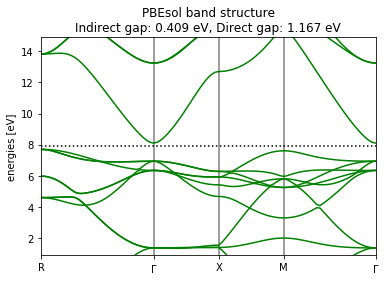

In [23]:
%matplotlib inline
from gpaw import GPAW
from ase.dft.bandgap import bandgap
import matplotlib.pyplot as plt
name = 'SrGeO3'  # Your perovskite name
calc = GPAW(f'bandgap/PBEsol/{name}_fixed_density.gpw', txt=None)
gap = bandgap(calc)[0]
gap_direct = bandgap(calc, direct=True)[0]
bs = calc.band_structure()
ax = bs.plot(show=False, emax=7, emin=-7)
ax.set_title(('PBEsol band structure\n'
              'Indirect gap: {:.3f} eV, '
              'Direct gap: {:.3f} eV').format(gap, gap_direct))
plt.savefig('PBEsol_bandstructure.png')
plt.show()